# exp027

In [1]:
MODE = 'local_train'
#MODE = 'kaggle_inference'

In [2]:
exp_name = 'exp027'
memo = ''

In [3]:
import os
import sys
import gc

if MODE == 'local_train':
    sys.path.append('/home/kaggler/.local/lib/python3.8/site-packages')
    from dotenv import load_dotenv
    load_dotenv
    sys.path.append(os.getenv('UTILS_PATH'))
    import line_notify
    import slack_notify
    
if MODE == "kaggle_inference":
    from cuml import ForestInference
    import treelite
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("ggplot")
import seaborn as sns
from sklearn.metrics.pairwise import haversine_distances
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb
import itertools
from scipy.spatial.distance import canberra
from sklearn.neighbors import KNeighborsRegressor
import functools
import multiprocessing
import Levenshtein
import difflib
import pickle
from tqdm import tqdm
%load_ext Cython

from transformers import DistilBertModel, DistilBertTokenizer, AutoModel, AutoTokenizer, BertTokenizer, BertModel
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torch.nn as nn
import torch

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
# directry_setting
if MODE == 'local_train':
    INPUT_DIR = os.getenv('INPUT_DIR')
    OUTPUT_DIR = os.getenv('OUTPUT_DIR')
    MODEL_DIR = os.getenv('OUTPUT_DIR')
    BERT_PATH_DISTILBERT_BASE_UNCASED = "distilbert-base-uncased"
    BERT_PATH_DISTILBERT_BASE_MULTILINGUAL_CASED = "distilbert-base-multilingual-cased"
    BERT_PATH_XLM_ROBERTA_BASE = "xlm-roberta-base"
    BERT_PATH_BERT_BASE_JAPANESE = "cl-tohoku/bert-base-japanese"
    BERT_PATH_BERT_BASE_JAPANESE_WHOLE_WORD_MASKING = "cl-tohoku/bert-base-japanese-whole-word-masking"
    BERT_PATH_BERT_BASE_TURKISH_CASED = "dbmdz/bert-base-turkish-cased"
    BERT_PATH_INDOBERT_BASE_UNCASED = "indolem/indobert-base-uncased"
    BERT_PATH_BERT_BASE_TH_CASED = "Geotrend/bert-base-th-cased"
    BERT_PATH_BERT_BASE_MULTILINGUAL_UNCASED = "bert-base-multilingual-uncased"


    os.makedirs(OUTPUT_DIR + exp_name, exist_ok=True)

elif MODE == 'kaggle_inference':
    INPUT_DIR = '/kaggle/input/foursquare-location-matching/'
    OUTPUT_DIR = './'
    MODEL_DIR = f'../input/fs{exp_name}/'
    BERT_PATH_DISTILBERT_BASE_UNCASED = "../input/distilbertbaseuncased"
    BERT_PATH_DISTILBERT_BASE_MULTILINGUAL_CASED = ""
    BERT_PATH_XLM_ROBERTA_BASE = ""
    BERT_PATH_BERT_BASE_JAPANESE = ""
    BERT_PATH_BERT_BASE_JAPANESE_WHOLE_WORD_MASKING = ""
    BERT_PATH_BERT_BASE_TURKISH_CASED = ""
    BERT_PATH_INDOBERT_BASE_UNCASED =  ""
    BERT_PATH_BERT_BASE_TH_CASED = ""
    BERT_PATH_BERT_BASE_MULTILINGUAL_UNCASED = ""

In [5]:
# CONFIG
SEED = 42
N_NEIGHBORS = 10
N_SPLITS = 5
PROB_TH = 0.5
MAX_LEN = 32
BS = 1024
NW = 2
SVD_N_COMP = 50

In [6]:
class InferenceDataset(Dataset):
    
    def __init__(self, df, max_len, col, tokenizer):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.col = col

    def __getitem__(self, index):
        row = self.df.iloc[index]
        
        inputs = self.tokenizer.encode_plus(
            row[self.col],
            None,
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True
        )
        ids = torch.LongTensor(inputs['input_ids'])
        mask = torch.LongTensor(inputs['attention_mask'])

        return ids, mask

    def __len__(self):
        return self.df.shape[0]

def bert_inference(model, tokenizer, df, col):
    model = model.cuda()
    ds = InferenceDataset(df, max_len=MAX_LEN, col=col, tokenizer=tokenizer)
    loader = DataLoader(ds, batch_size=BS, shuffle=False, num_workers=NW,
                        pin_memory=False, drop_last=False)
    vs = []
    with torch.no_grad():
        for idx, (ids, masks) in enumerate(tqdm(loader)):
            v = model(ids.cuda(), masks.cuda()).detach().cpu().numpy()
            vs.append(v)
    return np.concatenate(vs)

In [7]:
def add_bert_similarity(df, col, model_name):
    df_ = pd.concat([df[col], df["match_" + col]]).drop_duplicates().to_frame()
    df_ = df_.reset_index(drop=True)
    df_.columns = [col]
    
    if model_name == "distilbert-base-uncased":
        model = DistilBertCat2VecModel(BERT_PATH_DISTILBERT_BASE_UNCASED)
        tokenizer = DistilBertTokenizer.from_pretrained(BERT_PATH_DISTILBERT_BASE_UNCASED, do_lower_case=True)

    if model_name == "distilbert-base-multilingual-cased":
        model = DistilBertCat2VecModel(BERT_PATH_DISTILBERT_BASE_MULTILINGUAL_CASED)
        tokenizer = DistilBertTokenizer.from_pretrained(BERT_PATH_DISTILBERT_BASE_MULTILINGUAL_CASED, do_lower_case=True)

    if model_name == "xlm-roberta-base":
        model = XlmRobertaCat2VecModel(BERT_PATH_XLM_ROBERTA_BASE)
        tokenizer = AutoTokenizer.from_pretrained(BERT_PATH_XLM_ROBERTA_BASE)

    if model_name == "bert_base_japanese":
        model = BertCat2VecModel(BERT_PATH_BERT_BASE_JAPANESE)
        tokenizer = BertTokenizer.from_pretrained(BERT_PATH_BERT_BASE_JAPANESE)

    if model_name == "bert-base-japanese-whole-word-masking":
        model = BertCat2VecModel(BERT_PATH_BERT_BASE_JAPANESE_WHOLE_WORD_MASKING)
        tokenizer = BertTokenizer.from_pretrained(BERT_PATH_BERT_BASE_JAPANESE_WHOLE_WORD_MASKING)

    if model_name == "bert-base-turkish-cased":
        model = BertCat2VecModel(BERT_PATH_BERT_BASE_TURKISH_CASED)
        tokenizer = BertTokenizer.from_pretrained(BERT_PATH_BERT_BASE_TURKISH_CASED)

    if model_name == "indobert-base-uncased":
        model = BertCat2VecModel(BERT_PATH_INDOBERT_BASE_UNCASED)
        tokenizer = BertTokenizer.from_pretrained(BERT_PATH_INDOBERT_BASE_UNCASED)

    if model_name == "bert-base-th-cased":
        model = BertCat2VecModel(BERT_PATH_BERT_BASE_TH_CASED)
        tokenizer = BertTokenizer.from_pretrained(BERT_PATH_BERT_BASE_TH_CASED)

    if model_name == "bert-base-multilingual-uncased":
        model = BertCat2VecModel(BERT_PATH_BERT_BASE_MULTILINGUAL_UNCASED)
        tokenizer = BertTokenizer.from_pretrained(BERT_PATH_BERT_BASE_MULTILINGUAL_UNCASED)
        
    V = bert_inference(model, tokenizer, df_, col)
    svd = TruncatedSVD(n_components=SVD_N_COMP, random_state=SEED)
    V = svd.fit_transform(V)
    V = V.astype("float16")
    bert_vec = {k:v for k,v in zip(df_[col].values, V)}

    sim_list = []
    for str1, str2 in tqdm(df[[f"{col}", f"match_{col}"]].values.astype(str)):
        if str1!="nan" and str2!="nan":
            sim = cosine_similarity(bert_vec[str1].reshape(1, -1), bert_vec[str2].reshape(1, -1))[0][0]
        else:
            sim = -1
        sim_list.append(sim)
    df[f"bert_sim_{col}"] = sim_list
    df[f"bert_sim_{col}"] = df[f"bert_sim_{col}"].astype(np.float16)
    return df

In [8]:
class DistilBertCat2VecModel(nn.Module):
    def __init__(self, bert_model):
        super(DistilBertCat2VecModel, self).__init__()
        self.distill_bert = DistilBertModel.from_pretrained(bert_model)
        
    def forward(self, ids, mask):
        x = self.distill_bert(ids, mask)[0]
        x = F.normalize((x[:, 1:, :]*mask[:, 1:, None]).mean(axis=1))
        return x

class XlmRobertaCat2VecModel(nn.Module):
    def __init__(self, bert_model):
        super(XlmRobertaCat2VecModel, self).__init__()
        self.backbone = AutoModel.from_pretrained(bert_model)
        
    def forward(self, ids, mask):
        x = self.backbone(ids, mask)[0]
        x = F.normalize((x[:, 1:, :]*mask[:, 1:, None]).mean(axis=1))
        return x

class BertCat2VecModel(nn.Module):
    def __init__(self, bert_model):
        super(BertCat2VecModel, self).__init__()
        self.backbone = BertModel.from_pretrained(bert_model)
        
    def forward(self, ids, mask):
        x = self.backbone(ids, mask)[0]
        x = F.normalize((x[:, 1:, :]*mask[:, 1:, None]).mean(axis=1))
        return x


In [9]:
train = pd.read_csv(OUTPUT_DIR + 'exp027/first_stage_data.csv', usecols=["name", "match_name", "country", "point_of_interest", "match_point_of_interest"])
train['target'] = (train['point_of_interest'] == train['match_point_of_interest']).values.astype(int)
train["target"] = train["target"].fillna(0)

In [10]:
train["country"].value_counts().head(20)

us    2209034
tr    1036621
id     997193
jp     630288
th     529272
ru     513270
br     461169
my     416934
be     232392
gb     229896
ph     199620
mx     192564
sg     189045
kr     171783
de     160317
fr     127566
es     116307
ca     107343
it     102555
sa      97803
Name: country, dtype: int64

In [11]:
train = train[train["country"].isin(["us", "tr", "id", "jp", "th"])].copy()
train = train[train["name"]!=train["match_name"]].copy()
train = train.reset_index(drop=True)
train["name"] = train["name"].astype(str)
train["match_name"] = train["match_name"].astype(str)

In [12]:
def show_hist(df, title):
    plt.hist(df.loc[df["target"]==0, "bert_sim_name"], color="blue", label="target=0", bins=40, alpha=0.8, density=True)
    plt.hist(df.loc[df["target"]==1, "bert_sim_name"], color="red", label="target=0", bins=40, alpha=0.8, density=True)
    plt.legend()
    plt.xlim(0,1)
    plt.title(title)
    plt.savefig(OUTPUT_DIR + exp_name + "/" + title + ".png")
    plt.show()

In [13]:
from sklearn.metrics import f1_score
def calc_score(df):
    best_score = 0
    best_th = np.nan

    for th in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
        df["pred"] = np.nan
        df.loc[df["bert_sim_name"]>th, "pred"] = 1
        df["pred"] = df["pred"].fillna(0)
        score = f1_score(df["target"], df["pred"]).astype("float16")

        if score > best_score:
            best_score = score
            best_th = th
    
    return best_th, best_score

Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 5291010/5291010 [11:52<00:00, 7421.95it/s]


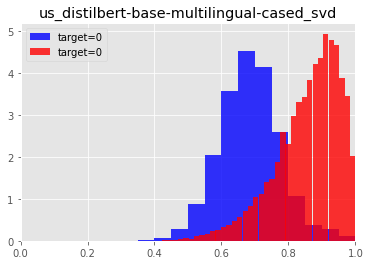

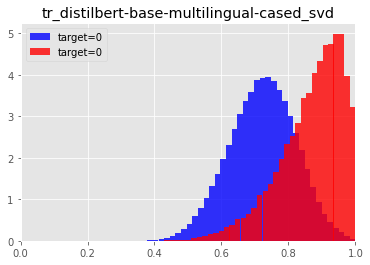

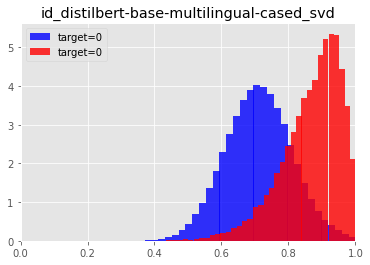

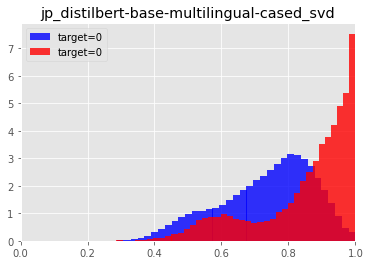

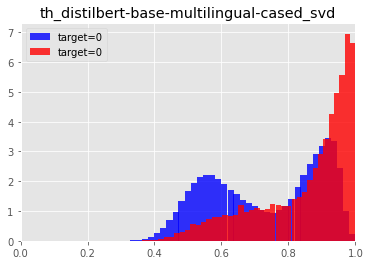

In [14]:
result_models = []
result_countries = []
result_ths = []
result_scores = []


models = [
          #"distilbert-base-uncased",
          "distilbert-base-multilingual-cased"
          #"xlm-roberta-base",
          #"bert_base_japanese",
          #"bert-base-japanese-whole-word-masking",
          #"bert-base-turkish-cased",
          #"indobert-base-uncased",
          #"bert-base-th-cased",
          #"bert-base-multilingual-uncased"
          ]
          
countries = ["us", "tr", "id", "jp", "th"]

for model in models:
    train = add_bert_similarity(train, "name", model)
    
    for country in countries:
        tmp = train[train["country"]==country].copy()
        show_hist(tmp, f"{country}_{model}_svd")
        best_th, best_score = calc_score(tmp)
        result_models.append(model)
        result_countries.append(country)
        result_ths.append(best_th)
        result_scores.append(best_score)

    train = train.drop(columns=["bert_sim_name"])

result = pd.DataFrame()
result["model"] = result_models
result["country"] = result_countries
result["best_th"] = result_ths
result["best_score"] = result_scores
result["type"] = "bert_sim_name_svd50"

In [15]:
result.to_csv(OUTPUT_DIR + f"{exp_name}/result3.csv", index=False)
result.head(20)

,model,country,best_th,best_score,type
0,distilbert-base-multilingual-cased,us,0.9,0.437012,bert_sim_name_svd50
1,distilbert-base-multilingual-cased,tr,0.9,0.488770,bert_sim_name_svd50
2,distilbert-base-multilingual-cased,id,0.9,0.467529,bert_sim_name_svd50
3,distilbert-base-multilingual-cased,jp,0.9,0.329346,bert_sim_name_svd50
4,distilbert-base-multilingual-cased,th,0.9,0.226685,bert_sim_name_svd50
